Vocabulary size 201


(array([1.190e+02, 1.660e+02, 1.310e+02, 1.400e+02, 1.380e+02, 1.590e+02,
        4.920e+02, 4.416e+03, 4.679e+03, 1.523e+03, 3.700e+02, 1.200e+02,
        4.400e+01, 8.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.00000e+00, 1.51650e+02, 3.01300e+02, 4.50950e+02, 6.00600e+02,
        7.50250e+02, 8.99900e+02, 1.04955e+03, 1.19920e+03, 1.34885e+03,
        1.49850e+03, 1.64815e+03, 1.79780e+03, 1.94745e+03, 2.09710e+03,
        2.24675e+03, 2.39640e+03, 2.54605e+03, 2.69570e+03, 2.84535e+03,
        2.99500e+03]),
 <BarContainer object of 20 artists>)

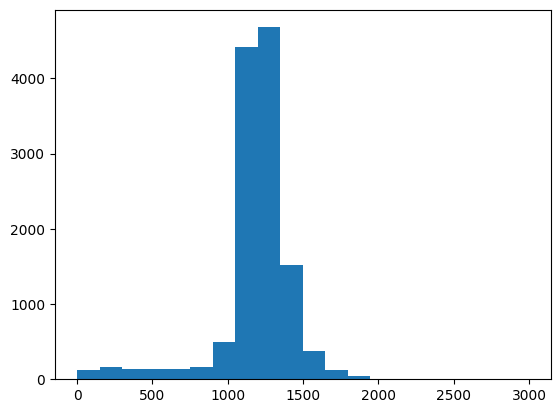

In [1]:
import numpy as np
import pandas as pd
import requests
import random
import string
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
import keras
from scipy.optimize import curve_fit
import time

CTX_LENGTH = 10
TEXT_LENGTH = 350
BLOCK_COUNT = 1000

# URL-ul datasetului pe care îl folosim
csv_url = 'https://huggingface.co/datasets/readerbench/ro-stories/resolve/main/ro_paragraphs_12516.csv'

# Descărcăm CSV-ul
response = requests.get(csv_url)
csv_content = response.content.decode('utf-8')

# Salvăm CSV-ul local
with open('ro_stories.csv', 'w', encoding='utf-8') as file:
    file.write(csv_content)

# Încărcăm într-un DataFrame Pandas
df = pd.read_csv('ro_stories.csv')

# Tokenizer pe litere
# Hot-swappable cu tokenizerele HuggingFace
class LetterTokenizer:
    def __init__(self, txt):
        self.letters = list(set(''.join(txt)))
        self.vocab_size = len(self.letters)
        self.token_to_id = {char: idx for idx, char in enumerate(self.letters)}
        self.id_to_token = {idx: char for idx, char in enumerate(self.letters)}
        self.pad_token_id = self.token_to_id[" "]  # Folosim space pt padding

    def encode(self, text):
        text = text.lower()  # Ignorăm case-ul textului
        return [self.token_to_id[char] for char in text if char in self.token_to_id]

    def decode(self, token_ids):
        return "".join([self.id_to_token[token_id] for token_id in token_ids])

tokenizer = LetterTokenizer(df.paragraph.to_list())
print("Vocabulary size " + str(tokenizer.vocab_size))

# Encodăm toate paragrafurile alese
paragraphs = df.paragraph.apply(lambda x: tokenizer.encode(x)).to_list()

# Afișăm o histogramă cu lungimile să
# știm ~ la ce lungime să uniformizăm
lens = [len(x) for x in paragraphs]
plt.hist(lens, bins=20)

In [2]:
import random


def reset_numpy_seed(seed_value=42):
  try:
    # Set NumPy random seed
    import numpy as np
    np.random.seed(seed_value)
    print(f'NumPy random seed set with value: {seed_value}')
  except Exception as e:
    print(f'NumPy random seed was not set: {e}')
  return


def reset_tensorflow_seed(seed_value=42):
  try:
    # Set TensorFlow random seed
    import tensorflow as tf
    success = False
    # Here we have 2 different ways to set the seed
    # depending on the version of TensorFlow
    try:
      tf.random.set_seed(seed_value)
      success = True
    except Exception as e:
      pass
    try:
      tf.set_random_seed(seed_value)
      success = True
    except Exception as e:
      pass
    if success:
      print(f'TensorFlow random seed set with value: {seed_value}')
    else:
      print(f'TensorFlow random seed was not set')
  except Exception as e:
    print(f'TensorFlow random seed was not set: {e}')
  return


def reset_torch_seed(seed_value=42):
  try:
    # Set PyTorch random seed
    import torch
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value)  # if you are using multiple GPUs
    print(f'PyTorch random seed set with value: {seed_value}')
  except Exception as e:
    print(f'PyTorch random seed was not set: {e}')
  return


def set_random_seeds(seed_value=42):
  # Set Python random seed
  random.seed(seed_value)
  reset_numpy_seed(seed_value)
  reset_tensorflow_seed(seed_value)
  reset_torch_seed(seed_value)
  return


if __name__ == '__main__':
  # Set the desired seed value
  seed = 42

  # Set random seeds
  set_random_seeds(seed)

NumPy random seed set with value: 42
TensorFlow random seed set with value: 42
PyTorch random seed set with value: 42


In [3]:
def uniformize_length(paragraph, length, rev=False):
    if len(paragraph) > length:
        return paragraph[:length] if not rev else paragraph[-length:]
    else:
        return (paragraph + [tokenizer.pad_token_id] * (length - len(paragraph))) if not rev else ([tokenizer.pad_token_id] * (length - len(paragraph)) + paragraph)

# Uniformizăm lungimile paragrafurilor
dataset = [uniformize_length(x, TEXT_LENGTH + 1) for x in random.sample(paragraphs, BLOCK_COUNT)]
inputs = np.array(dataset)

# Formăm np-array-urile de X,y cu input/output
def prepare_input_output(inputs, ctx_length, vocab_size):
    X = []
    y = []
    for input_t in inputs:
        for i in range(ctx_length, input_t.shape[0] - ctx_length):
            input_block = input_t[i:i + ctx_length]
            target_block = input_t[i + ctx_length]
            
            input_block = tf.one_hot(input_block, depth=vocab_size).numpy()
            target_block = tf.one_hot(target_block, depth=vocab_size).numpy()

            X.append(input_block)
            y.append(target_block)

    return np.array(X), np.array(y)

X, y = prepare_input_output(inputs, CTX_LENGTH, tokenizer.vocab_size)

In [16]:
# Verificare hardware CPU/GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("Using GPU")
else:
    print("Using CPU")

# Definim arhitectura modelului

# MLP
'''
model = Sequential([
    Dense(500, input_shape=(CTX_LENGTH, tokenizer.vocab_size), activation='gelu'),
    Dense(500, activation='gelu'),
    Dense(tokenizer.vocab_size, activation='softmax')
])
'''

# RNN
model = Sequential(
    [
        keras.layers.LSTM(512, input_shape=(CTX_LENGTH, tokenizer.vocab_size), return_sequences=False),
        keras.layers.Dense(tokenizer.vocab_size, activation="softmax"),
    ]
)

Num GPUs Available:  0
Using CPU


'\n# RNN\nmodel = Sequential(\n    [\n        keras.layers.LSTM(512, input_shape=(CTX_LENGTH, tokenizer.vocab_size), return_sequences=False),\n        keras.layers.Dense(tokenizer.vocab_size, activation="softmax"),\n    ]\n)\n'

In [10]:
# Funcție care să se plieze pe loss (+/- logaritmic)
def logarithmic_decay(x, a, b, c, d):
    return -(a * np.log(x * b + c) + d)         # Adaptat din formula pt cross-entropy loss

# Average-uim valorile pt un curve mai smooth
def average_every_n_values(arr, n):
    return np.mean(np.pad(arr, (0, n - len(arr) % n), mode='edge').reshape(-1, n), axis=1)

# O clasă custom cu un simplu curve fitter ca să putem
# prezice loss-ul în timp real pentru a avea un 
# feedback mai bun asupra performanței modelului
# fără să antrenăm o epocă întreagă
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
        self.history_losses = []
        self.offset = 30                # Ignorăm anomalii de la început
        self.average_values = 5         # Smoothing
    
    def on_epoch_begin(self, epoch, logs=None):
        # Luăm nr de batch-uri pt epoca curentă
        self.total_batches = self.params['steps']
        self.epoch_time = time.time()
        self.offset = int(self.total_batches * 0.015)

    def on_batch_end(self, batch, logs):
        logs = logs or {}
        self.history_losses.append(logs.get('loss'))
        self.losses.append(logs.get('loss'))

        # Updatăm loss-ul prezis dacă avem destule date
        if len(self.losses) > self.offset + self.average_values * 3 + 1:  # Sigur avem destule puncte
            mean_losses = np.array(self.losses[self.offset:])
            mean_losses = average_every_n_values(mean_losses, self.average_values)
            x_data = np.arange(1, len(mean_losses) + 1)
            y_data = np.array(mean_losses)

            try:
                popt, _ = curve_fit(logarithmic_decay, x_data, y_data, maxfev=10000)    # Facem un curve fitting cu funcția noastră
                self.popt = popt
                x_final = (self.total_batches - self.offset - self.average_values * 3 + 1) / self.average_values
                final_loss = logarithmic_decay(x_final, *popt)     # Prezicem valoare de la ultimul batch

                current_loss = logarithmic_decay(len(mean_losses), *popt)
                final_loss = max(min(final_loss + current_loss - logs.get('loss'), 99), 0)
                logs['predicted_final_loss'] = final_loss
            except: pass
            
            # Accelerația loss-ului în timp
            logs['loss_delta_time'] = (mean_losses[0] - mean_losses[-1]) / (time.time() - self.epoch_time) * 1000
        else:
            logs['loss_delta_time'] = (self.losses[0] - self.losses[-1]) / (time.time() - self.epoch_time) * 1000

    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        self.losses = []

loss_history = LossHistory()

In [15]:
# Compilăm modelul + optimizer-ul
optimizer = Adam(learning_rate=1e-3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Antrenăm modelul cu validation split
print('Starting training...')
history = model.fit(X, y, epochs=2, batch_size=128, callbacks=[learning_rate_reduction, loss_history], shuffle=True, validation_split=0.2)

# Afișăm loss-ul per epoci
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Starting training...
Epoch 1/2


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 201), output.shape=(None, 10, 201)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34148\3677465380.py:2: RuntimeWarning: invalid value encountered in log
  return -(a * np.log(x * b + c) + d)


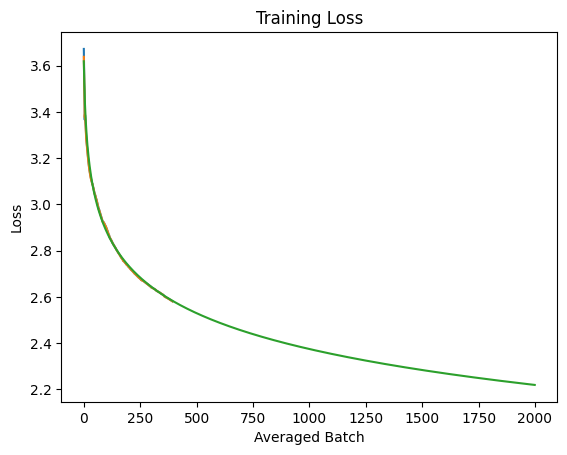

[ 0.22463707  0.22084396  0.87414899 -3.58818296]


In [7]:
def logarithmic_decay_test(x, a, b, c, d):
    return -(a * np.log(x * b + c) + d)

def calc_curve(value_count):
    mean_losses = np.array(loss_history.history_losses[loss_history.offset:value_count])
    mean_losses = average_every_n_values(mean_losses, loss_history.average_values)
    x_data = np.arange(1, len(mean_losses) + 1)
    y_data = np.array(mean_losses)

    popt, _ = curve_fit(logarithmic_decay_test, x_data, y_data, maxfev=10000)
    return mean_losses, popt, logarithmic_decay_test(np.arange(0, value_count).astype('float64'), *popt)

# Afișăm loss-ul per batch-uri + loss-ul prezis (pentru prima epocă)
look_back_count = 2000
mean_losses, popt, lst = calc_curve(look_back_count)
plt.plot(loss_history.history_losses[loss_history.offset:look_back_count:loss_history.average_values])
plt.plot(mean_losses)
plt.plot(lst)
plt.plot()
plt.title('Training Loss')
plt.xlabel('Averaged Batch')
plt.ylabel('Loss')
plt.show()

print(popt)

In [8]:
# Prezicem următoarele token-uri din secvență
def predict_tokens(prompt, length, temperature=0.6):
    prompt_tokens = tokenizer.encode(prompt)
    for _ in range(length):
        input_tokens = uniformize_length(prompt_tokens, CTX_LENGTH, rev=True)
        input_t = tf.one_hot(input_tokens, depth=tokenizer.vocab_size).numpy()
        # Trebuie să ne potrivim dimenisunile la [samples, time steps, features]
        input_t = input_t.reshape(1, CTX_LENGTH, tokenizer.vocab_size)

        output = model.predict(input_t, verbose=0)
        output = np.asarray(output).astype('float64')
        output = np.log(output + 1e-8) / temperature        # Ne folosim de temperatură pt creativitate
        exp_preds = np.exp(output)
        preds = exp_preds / np.sum(exp_preds)
        
        # Doar un sampling multinomial la final și append-uim la totalul de tokens
        next_token = np.random.choice(len(preds[0]), p=preds[0])
        prompt_tokens.append(next_token)
        print(tokenizer.decode(prompt_tokens) + ".")

    completion = tokenizer.decode(prompt_tokens)
    return completion

# Prompt de test
prompt = "Amu cică era od"     # Creangă pt că e based
completion = predict_tokens(prompt, 100)
print(completion + ".")

amu cică era odi.
amu cică era odie.
amu cică era odie .
amu cică era odie a.
amu cică era odie al.
amu cică era odie alu.
amu cică era odie alui.
amu cică era odie alui .
amu cică era odie alui î.
amu cică era odie alui în.
amu cică era odie alui înc.
amu cică era odie alui încr.
amu cică era odie alui încre.
amu cică era odie alui încres.
amu cică era odie alui încrest.
amu cică era odie alui încrestă.
amu cică era odie alui încrestă .
amu cică era odie alui încrestă î.
amu cică era odie alui încrestă în.
amu cică era odie alui încrestă în .
amu cică era odie alui încrestă în a.
amu cică era odie alui încrestă în ac.
amu cică era odie alui încrestă în acu.
amu cică era odie alui încrestă în acut.
amu cică era odie alui încrestă în acut .
amu cică era odie alui încrestă în acut p.
amu cică era odie alui încrestă în acut pe.
amu cică era odie alui încrestă în acut pe .
amu cică era odie alui încrestă în acut pe î.
amu cică era odie alui încrestă în acut pe în.
amu cică era odie alui în

In [155]:
# Salvăm modelul dacă ne place
model.save_weights('./model.weights.h5')